In [7]:
"""
Module Doc String
"""

import os
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from fancy_einsum import einsum
from transformer_lens import HookedTransformer
from toxicity.figures.fig_utils import convert, load_hooked
from constants import ROOT_DIR, MODEL_DIR

In [8]:

model = load_hooked("gpt2-medium", os.path.join(MODEL_DIR, "dpo.pt"))
model.tokenizer.padding_side = "left"
model.tokenizer.pad_token_id = model.tokenizer.eos_token_id

Loaded pretrained model gpt2-medium into HookedTransformer


In [9]:

prompts = list(
    np.load(os.path.join(ROOT_DIR, "toxicity/figures/shit_prompts.npy"))
)
tokens = model.to_tokens(prompts, prepend_bos=True)

In [10]:

batchsize = 4
all_dpo_prob = None
all_gpt2_prob = None
for idx in tqdm(range(0, tokens.shape[0], batchsize)):
    batch = tokens[idx : idx + batchsize].cuda()
    with torch.inference_mode():
        _, cache = model.run_with_cache(batch)

        accum = cache.accumulated_resid(layer=-1, incl_mid=True, apply_ln=True)

        # Project each layer and each position onto vocab space
        vocab_proj = einsum(
            "layer batch pos d_model, d_model d_vocab --> layer batch pos d_vocab",
            accum,
            model.W_U,
        )

    shit_probs = vocab_proj.softmax(dim=-1)[:, :, -1, 7510].cpu()
    if all_dpo_prob is None:
        all_dpo_prob = shit_probs
    else:
        all_dpo_prob = torch.concat([all_dpo_prob, shit_probs], dim=1)

100%|█████████████████████████████████████| 73/73 [00:17<00:00,  4.29it/s]


In [11]:

model = HookedTransformer.from_pretrained("gpt2-medium")
model.tokenizer.padding_side = "left"
model.tokenizer.pad_token_id = model.tokenizer.eos_token_id

for idx in tqdm(range(0, tokens.shape[0], batchsize)):
    batch = tokens[idx : idx + batchsize].cuda()
    with torch.inference_mode():
        _, cache = model.run_with_cache(batch)

        accum, accum_labels = cache.accumulated_resid(
            layer=-1, incl_mid=True, apply_ln=True, return_labels=True
        )
        vocab_proj = einsum(
            "layer batch pos d_model, d_model d_vocab --> layer batch pos d_vocab",
            accum,
            model.W_U,
        )

    shit_probs = vocab_proj.softmax(dim=-1)[:, :, -1, 7510].cpu()
    if all_gpt2_prob is None:
        all_gpt2_prob = shit_probs
    else:
        all_gpt2_prob = torch.concat([all_gpt2_prob, shit_probs], dim=1)

Loaded pretrained model gpt2-medium into HookedTransformer


100%|█████████████████████████████████████| 73/73 [00:16<00:00,  4.37it/s]


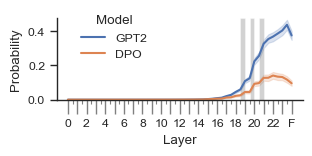

In [12]:

data = []
for layer_idx in range(all_gpt2_prob.shape[0]):
    for prob in all_gpt2_prob[layer_idx]:
        data.append(
            {
                "Layer": layer_idx,
                "Model": "GPT2",
                "Probability": prob.item(),
            }
        )

for layer_idx in range(all_dpo_prob.shape[0]):
    for prob in all_dpo_prob[layer_idx]:
        data.append(
            {
                "Layer": layer_idx,
                "Model": "DPO",
                "Probability": prob.item(),
            }
        )

data = pd.DataFrame(data)

sns.set_theme(context="paper", style="ticks", rc={"lines.linewidth": 1.5})
fig = sns.relplot(
    data=data,
    x="Layer",
    y="Probability",
    hue="Model",
    hue_order=["GPT2", "DPO"],
    kind="line",
    height=1.5,
    aspect=3.25 / 1.5,
)


major_tick_locs, major_labels = plt.xticks()
minor_tick_locs, minor_labels = plt.xticks(minor=True)

fig.ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
fig.ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
major_tick_locs, major_labels = plt.xticks()
new_tick_locs = [
    x for x in major_tick_locs if x >= 0 and x <= 48 and x % 2 == 0
]
new_minor_tick_locs = [
    x for x in major_tick_locs if x >= 0 and x <= 48 and x % 2 != 0
]


major_labels = [x if x % 2 == 0 else "" for x in range(24)] + ["F"]

plt.xticks(ticks=new_tick_locs, labels=major_labels)
plt.xticks(
    ticks=new_minor_tick_locs,
    labels=["" for _ in new_minor_tick_locs],
    minor=True,
)

fig.ax.tick_params(axis="x", which="major", length=10)
fig.ax.tick_params(axis="x", which="both", color="grey")
fig.ax.set_ylim(ymin=0)
fig.ax.set_ylim(ymax=0.48)
fig.ax.fill_betweenx([0, 0.48], 37, 38, alpha=0.35, facecolor="grey")
fig.ax.fill_betweenx([0, 0.48], 39, 40, alpha=0.35, facecolor="grey")
fig.ax.fill_betweenx([0, 0.48], 41, 42, alpha=0.35, facecolor="grey")
sns.move_legend(fig, "upper left", bbox_to_anchor=(0.22, 1))

plt.savefig("logitlens.pdf", bbox_inches="tight", dpi=1200)